# Automatic feature engineering in a linear system

In the [bivariate linear regression tutorial](LinearRegressionBivariate.html)[Notebook](LinearRegressionBivariate.ipynb), gave us the tools to perform linear regression on multiple variables. In the [bivariate Keras linear regression tutorial](LinearRegressionBivariate-Keras.html)[Notebook](LinearRegressionBivariate-Keras.ipynb), most of the plumbing of the optimization was delegated to Keras.

In this tutorial, we will use the Galton dataset of people height. Starting from a simple regression using parents' heights to estimate the child's height, the model will be improved to take into account for the child's sex. Eventually, we will try to get the model to learn the feature through a two level neural net based on Keras.


### Learning goals:
- [Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) top manually improve the model
- Observe the extraction and combination of features by a neural net, that's called [feature learning](https://en.wikipedia.org/wiki/Feature_learning)

In [1]:
from tensorflow import keras
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model, model_selection, preprocessing
import pandas as pd

//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1)

In [2]:
usingTensorBoard = False

## Helpers

In [3]:
def twinPlot(features, series, legend):
    """ Plot subplots horizontally """
    numPlots = len(features.columns)
    fig, axs = plt.subplots(1, numPlots, sharey=True, figsize=(16, 6))
    if numPlots == 1:
        t, v = features.iteritems()[0]
        for y in series:
            axs.scatter(v, y)
     #   axs[i].set_aspect('equal')
        axs.set_xlabel(t)
        axs.legend(legend)
        axs.set_title('Height [inch]')
    else:
        for i, c in enumerate(features.iteritems()):
            for y in series:
                axs[i].scatter(c[1], y)
          #  axs[i].set_aspect('equal')
            axs[i].set_xlabel(c[0])
        axs[0].legend(legend)
        axs[0].set_title('Height [inch]')

## Reading data

The choosen data model is the Galton dataset of human heights with parents' heights. It also contains the gender of each kid, that's the feature will attempt to automatically process.

In [4]:
df = pd.read_csv('Galton.txt', sep="\t") # http://www.randomservices.org/random/data/Galton.txt 
df.head()

,Family,Father,Mother,Gender,Height,Kids
0,1,78.5,67.0,M,73.2,4
1,1,78.5,67.0,F,69.2,4
2,1,78.5,67.0,F,69.0,4
3,1,78.5,67.0,F,69.0,4
4,2,75.5,66.5,M,73.5,4


Splitting train (80%) and test (20%)

In [5]:
(df_train, df_test) = model_selection.train_test_split(df, test_size=0.2)

## Linear regression on the parents' heights

In [6]:
model1 = linear_model.LinearRegression()

model1.fit(df_train[['Mother', 'Father']], df_train['Height'])
b1 = model1.intercept_
w1 = model1.coef_

print('Linear regression with 2 features, intercept = %.3f, weights = %.3f, %.3f' % (b1, w1[0], w1[1]))

Linear regression with 2 features, intercept = 22.097, weights = 0.287, 0.379


### Model evaluation

Mean squared error for global model : 11.743


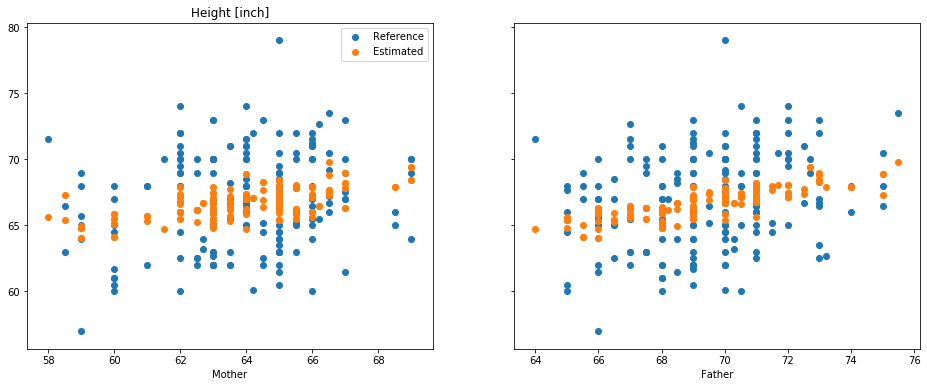

In [7]:
height_est1 = model1.predict(df_test[['Mother', 'Father']])
mse1 = metrics.mean_squared_error(df_test['Height'], height_est1)
twinPlot(df_test[['Mother', 'Father']], [ df_test['Height'], height_est1], ['Reference', 'Estimated'])
print("Mean squared error for global model : %.3f" % mse1)

We may guess or check on the residus that we are missing some fundamental information : the sex of the kid.
Let's redo the linear regression with separate models for kids and girls.

## Linear regression on the parents' heights with gendered models

In [8]:
girls_train = df_train['Gender'] == 'F'
girls_test = df_test['Gender'] == 'F'

model2_girl   = linear_model.LinearRegression()
model2_girl = linear_model.LinearRegression()

model2_girl.fit(df_train[['Mother', 'Father']][girls_train], df_train['Height'][girls_train])
b2_girl = model2_girl.intercept_
w2_girl = model2_girl.coef_

In [9]:
boys_train = df_train['Gender'] == 'M'
boys_test = df_test['Gender'] == 'M'

model2_boy   = linear_model.LinearRegression()

model2_boy.fit(df_train[['Mother', 'Father']][boys_train], df_train['Height'][boys_train])
b2_boy = model2_boy.intercept_
w2_boy = model2_boy.coef_

In [10]:
print('Linear regression with 2 features, fitting girls, intercept = %.3f, weights = %.3f, %.3f' % (b2_girl, w2_girl[0], w2_girl[1]))
print('Linear regression with 2 features, fitting boys,  intercept = %.3f, weights = %.3f, %.3f' % (b2_boy, w2_boy[0], w2_boy[1]))

Linear regression with 2 features, fitting girls, intercept = 21.218, weights = 0.255, 0.382
Linear regression with 2 features, fitting boys,  intercept = 15.951, weights = 0.355, 0.441


In [11]:
height_est2_boy = model2_boy.predict(df_test[['Mother', 'Father']][boys_test])
height_est2_girl = model2_girl.predict(df_test[['Mother', 'Father']][girls_test])

mse2 = 1 / len(df_test) * (np.sum((df_test['Height'][boys_test] - height_est2_boy)**2) +
                           np.sum((df_test['Height'][girls_test] - height_est2_girl)**2))

print("Mean squared error for split boy/girl model : %.3f" % mse2)

Mean squared error for split boy/girl model : 5.068


We observe a significant change in the coefficients, and a sharp decrease of the MSE

## Baseline model with Keras

In [12]:
scalerX = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
scalerX.fit(df_train[['Mother', 'Father']])
trainX_scaled = scalerX.transform(df_train[['Mother', 'Father']])

scalerY = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
scalerY.fit(df_train[['Height']])
trainY_scaled = scalerY.transform(df_train[['Height']])

In [13]:
# Number of epochs
nEpoch3 = 512
nBatch3 = 128 # 32 is default
nFeatures3 = 2

# Model
model3 = keras.models.Sequential([
  keras.layers.Dense(1, activation='linear', input_shape=[nFeatures3],
                   # bias_regularizer=keras.regularizers.l2(0.00001),     
                    kernel_regularizer=keras.regularizers.l2(0.0001))
])
model3.compile(optimizer='adam',
              loss=keras.losses.mean_squared_error,
              metrics=['mse'])

# Tensor board
callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs/", 
                                     histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]
    
# Fit
hist3 = model3.fit(trainX_scaled, trainY_scaled, 
                   epochs=nEpoch3, batch_size=nBatch3, validation_split = 0.2, verbose=0, callbacks=callbacks)

w3, b3 = model3.get_weights()
print('Scaled intercept = %.3f, Weights = ' % b3[0], w3.reshape(-1))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Scaled intercept = 0.033, Weights =  [0.18385457 0.28484607]


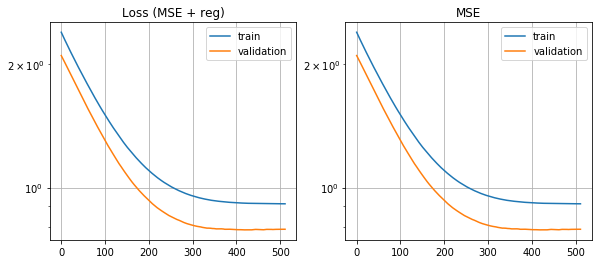

In [14]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.semilogy(hist3.history['loss'])
plt.semilogy(hist3.history['val_loss'])
plt.grid()
plt.legend(('train', 'validation'))
plt.title('Loss (MSE + reg)');
plt.subplot(1,3,2)
plt.semilogy(hist3.history['mean_squared_error'])
plt.semilogy(hist3.history['val_mean_squared_error'])
plt.grid()
plt.legend(('train', 'validation'))
plt.title('MSE');

Mean squared error for Keras baseline model : 11.706, original mse: 11.743


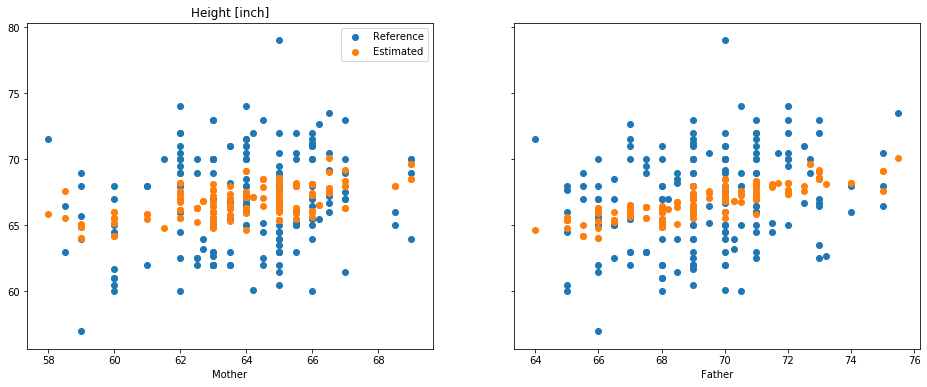

In [15]:
testX_scaled = scalerX.transform(df_test[['Mother', 'Father']])
# Predict
height_est3_scaled =  model3.predict(testX_scaled)
# Inverse scale
height_est3 = scalerY.inverse_transform(height_est3_scaled)

mse3 = metrics.mean_squared_error(df_test['Height'], height_est3)

twinPlot(df_test[['Mother', 'Father']], [df_test['Height'], height_est3], ['Reference', 'Estimated'])
print("Mean squared error for Keras baseline model : %.3f, original mse: %.3f" % (mse3, mse1))

The MSE on the test set is similar to the one of linear regression.

## Model with gender in Keras

Let's add the gender into the Keras model. In order to get symetrical handling of both sexes, we are first encoding the sex with a one hot encoder that is going to create two binary features corresponding to the sex:

|sex|enc1|enc2|
|---|----|----|
| M | 1 | 0 |
| F | 0 | 1 |

In [16]:
genderEncoder = preprocessing.OneHotEncoder(sparse=False)
genderEncoder.fit(df_train[['Gender']]);

In [17]:
# Number of epochs
nEpoch4 = 512
nBatch4 = 128 # 32 is default
nFeatures4 = 4

# Model
model4 = keras.models.Sequential([
  keras.layers.Dense(2, activation='linear', input_shape=[nFeatures4],
                     #bias_regularizer=keras.regularizers.l2(0.00001),
                     kernel_regularizer=keras.regularizers.l2(0.0001)),
  keras.layers.Dense(1, activation='linear', input_shape=[nFeatures4],
                     #bias_regularizer=keras.regularizers.l2(0.00001),
                     kernel_regularizer=keras.regularizers.l2(0.0001))
])
model4.compile(optimizer='adam',
              loss=keras.losses.mean_squared_error,
              metrics=['mse'])

# Tensor board
callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs/", 
                                     histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]
    
# Fit
xTrain4 = np.concatenate((trainX_scaled, 
                          genderEncoder.transform(df_train[['Gender']])), axis=1)
hist4 = model4.fit(xTrain4, trainY_scaled,
                   epochs=nEpoch4, batch_size=nBatch4, validation_split = 0.2, verbose=0, callbacks=callbacks)

In [18]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [19]:
model4.get_weights()

[array([[ 0.5606802 ,  0.3454165 ],
        [ 0.37854725,  0.06875143],
        [-1.7728195 , -0.15996307],
        [ 0.50359327,  0.5175908 ]], dtype=float32),
 array([ 0.33688506, -0.216247  ], dtype=float32),
 array([[ 0.9455671],
        [-0.9772694]], dtype=float32),
 array([0.23328122], dtype=float32)]

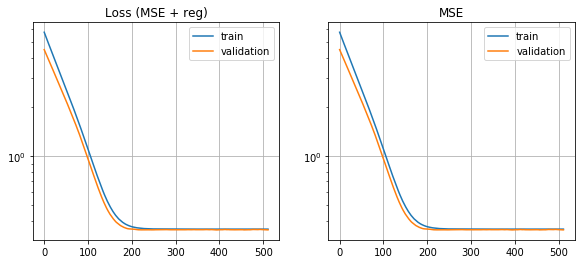

In [20]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.semilogy(hist4.history['loss'])
plt.semilogy(hist4.history['val_loss'])
plt.grid()
plt.legend(('train', 'validation'))
plt.title('Loss (MSE + reg)');
plt.subplot(1,3,2)
plt.semilogy(hist4.history['mean_squared_error'])
plt.semilogy(hist4.history['val_mean_squared_error'])
plt.grid()
plt.legend(('train', 'validation'))
plt.title('MSE');

Mean squared error for Keras model with genre : 4.932, original MSE : 5.068


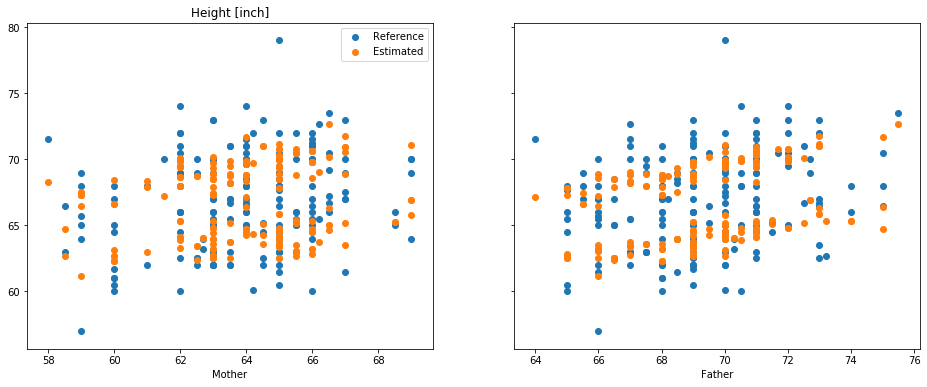

In [21]:
testX_scaled4 = np.concatenate((scalerX.transform(df_test[['Mother', 'Father']]), 
                         genderEncoder.transform(df_test[['Gender']])), axis=1)
height_est_scaled4 =  model4.predict(testX_scaled4)

height_est4 = scalerY.inverse_transform(height_est_scaled4)
mse4 = metrics.mean_squared_error(df_test['Height'], height_est4)

twinPlot(df_test[['Mother', 'Father']], [df_test['Height'], height_est4], ['Reference', 'Estimated'])
print("Mean squared error for Keras model with genre : %.3f, original MSE : %.3f" % (mse4, mse2))

## Conclusion

Using a little feature engineering (one hot encoding) and feature learning capabilities of the neural net, we have been able to learn a model taking into acount for the gender of the target child.

This simple example is extended in the large classification frameworks like AlexNet, VGG or GoogLeNet that are able to combine features extracted from images to eventually classify objects and animals.

The drawbacks are :
- More complex models : the provided model has 2 layers and 13 parameters, whereas the manually engineered model has 2*3=6 parameters
- Complex and tricky optimizations : the gradient descent on multi-layer neural networks requires attention and skills to get a repeatable and generalizable result

### Where to go from here :

__Compare with the two feature binary classification using logistic regression__ [using Keras](../classification/ClassificationContinuous2Features-Keras.html) ([Notebook](../classification/ClassificationContinuous2Features-Keras.ipynb]))

__Multi-class classification__ [with Keras](../classification/ClassificationMulti2Features-Keras.html) ([Notebook](../classification/ClassificationMulti2Features-Keras.ipynb))